In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import numpy as np
import tqdm
import os
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
class LQR:
    def __init__(self, H, M, C, D, R, T,sigma):
        self.H = torch.tensor(H, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)
        self.C = torch.tensor(C, dtype=torch.float32)
        self.D = torch.tensor(D, dtype=torch.float32)
        self.R = torch.tensor(R, dtype=torch.float32)
        self.T = T
        self.sigma = sigma 

    def solve_ricatti_ode(self, time_grid):
        H, M, C, D, R = self.H.numpy(), self.M.numpy(), self.C.numpy(), self.D.numpy(), self.R.numpy()
        T = self.T

        def ricatti_ode(t, S_flat):
            S = S_flat.reshape(2, 2)
            dSdt = -2 * H.T @ S + S @ M @ np.linalg.inv(D) @ M.T @ S - C
            return dSdt.flatten()
        sol = solve_ivp(ricatti_ode, [T, 0], R.flatten(), t_eval=np.flip(time_grid), vectorized=True,rtol=1e-6, atol=1e-9)
        S_values = sol.y.T.reshape(-1, 2, 2)
        S_values_tensor = torch.tensor(S_values, dtype=torch.float32)
        S_values_tensor_reversed = torch.flip(S_values_tensor, dims=[0])

        return S_values_tensor_reversed
    
    def control_problem_value(self, t, x):
        S_values = self.solve_ricatti_ode(t)
        v_values = torch.zeros(x.size(0), 1, dtype=torch.float32)  # 初始化 v_values
        # for cycle
        for i in range(x.size(0)):

            x_i = x[i]  # x_i shape (1, 2)
            S_i = S_values[i]  # S_i shape (2, 2)
            v_i = torch.matmul(torch.matmul(x_i.transpose(0, 1), S_i), x_i)  # 计算 x_i * S_i * x_i'
            
            integral_value = 0  # initialize integral
            if self.sigma is not None:  #  sigma_fix
                sigma_mat = torch.tensor(self.sigma, dtype=torch.float32)
                # integral_calculation
                for j in range(i, len(t) - 1):
                    S_j = S_values[j]  # get  S value at t_j
                    tr_value = torch.trace(torch.matmul(torch.matmul(sigma_mat, sigma_mat.transpose(0, 1)), S_j))
                    delta_t = t[j + 1] - t[j]  #  influence of time
                    integral_value += tr_value * delta_t  # influence of cumulative integral

            v_i += integral_value  
            v_values[i] = v_i
            
        return v_values
        
    def markov_control_function(self, t, x):
        S_values = self.solve_ricatti_ode(t)  # solve Ricatti ODE
        # calculate control a for each sample
        a_values = [-torch.inverse(self.D) @ self.M.T @ S_values[i].clone().detach().to(dtype=torch.float32) @ x_[None, :] for i, x_ in enumerate(x)]
        # Stack the tensors in the list into a new tensor with a shape of n×2×1
        a_values = torch.stack(a_values).squeeze(1)  # use squeeze(1)to cut extra dimension
        return a_values
    

In [3]:
class DGM_Layer(nn.Module):
    
    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(DGM_Layer, self).__init__()
        
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))
            

        self.gate_Z = self.layer(dim_x+dim_S, dim_S)
        self.gate_G = self.layer(dim_x+dim_S, dim_S)
        self.gate_R = self.layer(dim_x+dim_S, dim_S)
        self.gate_H = self.layer(dim_x+dim_S, dim_S)
            
    def layer(self, nIn, nOut):
        l = nn.Sequential(nn.Linear(nIn, nOut), self.activation)
        return l
    
    def forward(self, x, S):
        x_S = torch.cat([x,S],1)
        Z = self.gate_Z(x_S)
        G = self.gate_G(x_S)
        R = self.gate_R(x_S)
        
        input_gate_H = torch.cat([x, S*R],1)
        H = self.gate_H(input_gate_H)
        
        output = ((1-G))*H + Z*S
        return output
class Net_DGM(nn.Module):

    def __init__(self, dim_x, dim_S, activation='Tanh'):
        super(Net_DGM, self).__init__()

        self.dim = dim_x
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Tanh':
            self.activation = nn.Tanh()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'LogSigmoid':
            self.activation = nn.LogSigmoid()
        else:
            raise ValueError("Unknown activation function {}".format(activation))

        self.input_layer = nn.Sequential(nn.Linear(dim_x+1, dim_S), self.activation)

        self.DGM1 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM2 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)
        self.DGM3 = DGM_Layer(dim_x=dim_x+1, dim_S=dim_S, activation=activation)

        self.output_layer = nn.Linear(dim_S, 1)

    def forward(self,t,x):
        tx = torch.cat([t,x], 1)
        S1 = self.input_layer(tx)
        S2 = self.DGM1(tx,S1)
        S3 = self.DGM2(tx,S2)
        S4 = self.DGM3(tx,S3)
        output = self.output_layer(S4)
        return output

In [4]:
#generate the training data of lqr
H = [[0.1, 0.0],
     [0.0, 0.1]]
M = [[1, 0],
     [0, 1]]
C = [[0.0, 0.0],
     [0.0, 0.0]]
D = [[1, 0],
     [0, 1]]
R = [[10.0, 0.0],
     [0.0, 10.0]]
T = 1
sigma =np.array([[0.001], [0.001]])
N=100
lqr_target = LQR(H=H, M=M, C=C, D=D, R=R, T=T,sigma=sigma)

In [5]:
#generate  t
t_samples = np.linspace(0, 1, 199)
#generate x
num_points = 200
x_samples = torch.rand(num_points, 2) * 6 - 3

In [6]:
# initialize the net
dim_x = 2 
T = 1
net = Net_DGM(dim_x=dim_x, dim_S=100, activation='Tanh')
# define optimizer and loss function
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

In [7]:
#calculate each v
results = []

# for each x in space
for i, x in enumerate(x_samples):
    # expand cureent x to each t
    x_expanded = x.repeat((len(t_samples), 1)).unsqueeze(-1)  # match the length of t_samples
    # calculate v at corresponding (t, x)
    v_values = lqr_target.control_problem_value(t_samples, x_expanded)
    
    # stroge(t, x, v)
    for t, v in zip(t_samples, v_values):
        results.append((x.numpy(), t, v.item())) 

In [8]:
x_list, t_list, v_list = zip(*results)

# transfer into numpy array 
x_array = np.stack(x_list, axis=0)  # Stack to shape x_array as [num_samples, 2]
t_array = np.array(t_list)[:, None]  # shape t_array as [num_samples, 1]
v_array = np.array(v_list)[:, None]  

# transfer numpy to Tensor
x_tensor = torch.tensor(x_array, dtype=torch.float32)
t_tensor = torch.tensor(t_array, dtype=torch.float32)
v_tensor = torch.tensor(v_array, dtype=torch.float32)

# creat TensorDataset and DataLoader
dataset = TensorDataset(x_tensor, t_tensor, v_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [9]:
epochs = 1000  # training steps
training_loss = []

for epoch in range(epochs):
    epoch_loss = 0.0  # cumulative of each epoch's loss
    
    for x_batch, t_batch, v_batch in dataloader:
        optimizer.zero_grad()  # Clear the gradients for the next training step

        # Forward propagation: Passing x through the model to compute the predicted v.
        v_predicted = net(t_batch, x_batch)

        # calculate the loss
        loss = criterion(v_predicted, v_batch)

        # Backward propagation: Computing gradients of the loss with respect to the model parameters
        loss.backward()

        # update parameters
        optimizer.step()
        
        # total loss
        epoch_loss += loss.item()

    # average loss for each epoch
    avg_epoch_loss = epoch_loss / len(dataloader)

    # add to list
    training_loss.append(avg_epoch_loss)

    print(f'Epoch [{epoch}], Average Loss: {avg_epoch_loss:.4f}')

Epoch [0], Average Loss: 212.0153
Epoch [1], Average Loss: 40.9649
Epoch [2], Average Loss: 16.7339
Epoch [3], Average Loss: 9.2102
Epoch [4], Average Loss: 6.2932
Epoch [5], Average Loss: 5.3675
Epoch [6], Average Loss: 3.7632
Epoch [7], Average Loss: 3.1507
Epoch [8], Average Loss: 2.1857
Epoch [9], Average Loss: 2.1482
Epoch [10], Average Loss: 2.6584
Epoch [11], Average Loss: 2.8092
Epoch [12], Average Loss: 2.2426
Epoch [13], Average Loss: 3.4782
Epoch [14], Average Loss: 2.2244
Epoch [15], Average Loss: 1.5187
Epoch [16], Average Loss: 2.3650
Epoch [17], Average Loss: 1.2682
Epoch [18], Average Loss: 1.5903
Epoch [19], Average Loss: 1.5652
Epoch [20], Average Loss: 1.7463
Epoch [21], Average Loss: 1.5806
Epoch [22], Average Loss: 2.1650
Epoch [23], Average Loss: 1.0821
Epoch [24], Average Loss: 1.0033
Epoch [25], Average Loss: 1.3063
Epoch [26], Average Loss: 1.3177
Epoch [27], Average Loss: 1.7919
Epoch [28], Average Loss: 1.6008
Epoch [29], Average Loss: 0.7879
Epoch [30], Aver

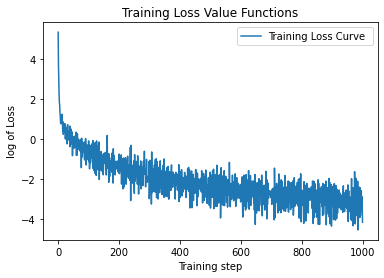

In [28]:
plt.plot(np.log((training_loss)), label='Training Loss Curve ')
plt.xlabel('Training step')
plt.ylabel('log of Loss')
plt.title('Training Loss Value Functions')
plt.legend()
plt.show()

In [22]:
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()
        
        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x)


In [16]:
dim_x = 3  
output_dim = 2
hidden_layers = [100,100]  # set number of hidden_layers

# define the structure of net
model = FFN([dim_x] + hidden_layers + [output_dim], activation=nn.ReLU, output_activation=nn.Identity)

In [17]:
optimizer_2 = torch.optim.Adam(model.parameters(), lr=0.0001)  # 定义优化器
criterion_2 = torch.nn.MSELoss() 

In [18]:
#We set x_train data and t_train data as before

results2 = []
# for each x in space
for i, x in enumerate(x_samples):
    # expand current x to each t
    x_expanded = x.repeat((len(t_samples), 1)).unsqueeze(-1)
    # use markov_control_function to calculate corresponding a
    a_values = lqr_target.markov_control_function(t_samples, x_expanded)
    
    # storage (t, x, a) into list
    for t, a in zip(t_samples, a_values):
        results2.append((x.numpy(), t, a.squeeze().numpy()))

In [19]:
x_data = np.array([item[0] for item in results2])
t_data = np.array([item[1] for item in results2]).reshape(-1, 1)  # 使t_data成为列向量以便合并
a_data = np.array([item[2] for item in results2])


inputs = np.hstack((x_data, t_data))
targets = a_data


inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)


dataset = TensorDataset(inputs_tensor, targets_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [20]:
epochs = 500  
training_loss2 = []

for epoch in range(epochs):
    epoch_loss2 = 0.0  # cumulative of each epoch's loss
    for inputs_batch, targets_batch in dataloader:
        optimizer_2.zero_grad()  
        outputs = model(inputs_batch) 
        loss = criterion_2(outputs, targets_batch)  
        loss.backward()  
        optimizer_2.step()  
        epoch_loss2 += loss.item()
        
    # average loss for each epoch
    avg_epoch_loss2 = epoch_loss2 / len(dataloader)

    # add to list
    training_loss2.append(avg_epoch_loss2)

    print(f'Epoch [{epoch}], Average Loss: {avg_epoch_loss2:.4f}')

Epoch [0], Average Loss: 17.9553
Epoch [1], Average Loss: 9.7581
Epoch [2], Average Loss: 8.3734
Epoch [3], Average Loss: 6.8428
Epoch [4], Average Loss: 5.5340
Epoch [5], Average Loss: 4.6534
Epoch [6], Average Loss: 4.1775
Epoch [7], Average Loss: 3.8702
Epoch [8], Average Loss: 3.5900
Epoch [9], Average Loss: 3.3453
Epoch [10], Average Loss: 3.0975
Epoch [11], Average Loss: 2.8505
Epoch [12], Average Loss: 2.6027
Epoch [13], Average Loss: 2.3598
Epoch [14], Average Loss: 2.1273
Epoch [15], Average Loss: 1.9124
Epoch [16], Average Loss: 1.7147
Epoch [17], Average Loss: 1.5394
Epoch [18], Average Loss: 1.3742
Epoch [19], Average Loss: 1.2306
Epoch [20], Average Loss: 1.1039
Epoch [21], Average Loss: 0.9932
Epoch [22], Average Loss: 0.8947
Epoch [23], Average Loss: 0.8083
Epoch [24], Average Loss: 0.7310
Epoch [25], Average Loss: 0.6658
Epoch [26], Average Loss: 0.6071
Epoch [27], Average Loss: 0.5569
Epoch [28], Average Loss: 0.5122
Epoch [29], Average Loss: 0.4715
Epoch [30], Average

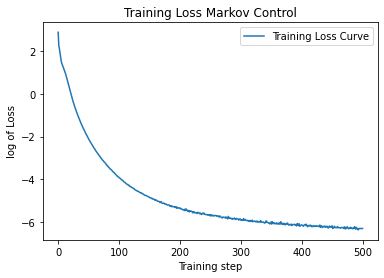

In [27]:
# creat loss figure
plt.plot(np.log((training_loss2)), label='Training Loss Curve')
plt.xlabel('Training step')
plt.ylabel('log of Loss')
plt.title('Training Loss Markov Control')
plt.legend()
plt.show()